In [1]:
# The following is from "big run"
import sys
sys.path.append('..')
from lib import *
import pandas as pd
import numpy as np

# Setup
lsa_np = np.load('../data/parsed/lsa_output.npy')
metadata = pd.read_pickle('../data/parsed/pickles/pickled_data_test.pickle')
metadata = metadata.loc[metadata['Scenario'] == '401']
metadata = metadata.reset_index(drop=True)
lsa_df = pd.DataFrame(lsa_np)
df = pd.concat([metadata, lsa_df], axis=1, join_axes=[metadata.index])
df = df.loc[df['Label'] != '-1']
df = df.reset_index(drop=True)
cat_features = ['To','From']
features = list(range(100))
features.extend(cat_features + ['Date'])
# features.extend(cat_features + ['ID'])

df = df[features + ['Label'] + ['ID']]
# df = df[features + ['ID']]


# Built-in incremental learning vs trees training on larger initial sizes

## Initializing control variables

In [2]:
# now using params from sweep

n_trees = 32
tree_depth = 10
random_seed = 42
n_max_features = 20
cat_features = ['To', 'From']

## Forests Trained on increasing datasets

In [ ]:
forest_100 = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
forest_200 = RNF(df[:200], n_trees, tree_depth, random_seed, n_max_features, 200, cat_features)
forest_300 = RNF(df[:300], n_trees, tree_depth, random_seed, n_max_features, 300, cat_features)
forest_400 = RNF(df[:400], n_trees, tree_depth, random_seed, n_max_features, 400, cat_features)
forest_500 = RNF(df[:500], n_trees, tree_depth, random_seed, n_max_features, 500, cat_features)
incremental_forests = [forest_100, forest_200, forest_300, forest_400, forest_500]

In [ ]:
for forest in incremental_forests:
    forest.fit_parallel()

In [ ]:
# evaluation
for forest in incremental_forests:
    print(evalStats(forest.predict_parallel(df[-100:])[1], df[-100:]), end='\n\n')

100, 200, ..., 500 document - trained forests
Param

##  Incremental Forests

In [5]:
incremental_forest = RNF(df[0:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)

In [6]:
incremental_forest.fit_parallel()
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

(0.2857142857142857, 1.0, 0.75, 0.4444444444444445)


In [7]:
incremental_forest.update(df[100:200])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[200:300])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[300:400])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[400:500])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

15
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999)
16
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999)
20
(0.7714285714285715, 0.8181818181818182, 0.86, 0.7941176470588236)
16
(0.8857142857142857, 0.5081967213114754, 0.66, 0.6458333333333334)


In [ ]:
incremental_forest.train_data.shape[0]

In [ ]:
forest_500.train_data.shape[0]

# Testing limited core usage

In [ ]:
f = RNF(df[0:500], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
f.fit_parallel()

In [ ]:
f.trees[20].visualize()

# Testing 400 incremented vs 400 initial trained

In [ ]:
# incremental forest initially trained on 100 rows
inc_forest = RNF(df[0:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
inc_forest.fit_parallel();

In [ ]:
init_forest = RNF(df[:-100], n_trees, tree_depth, random_seed, n_max_features, 400, cat_features)
init_forest.fit_parallel();

# Comparing Query Strategies

## Query by Committee
Asking for labeling on rows with the most amount of disagreement (between trees)

In [ ]:
committee_rnf = RNF(df[:500], n_trees, tree_depth, random_seed, n_max_features, 500, cat_features)
committee_rnf.fit_parallel()

In [ ]:
predictions = committee_rnf.predict_parallel(df[-100:])

In [3]:
# agreements = predictions[0]
def entropy(pred):
    s = 0
    for x in pred[0]:
        if x != 0:
            s += x * math.log(x)
    return (-1 * s, pred[1])

# entropies = sorted(map(entropy, zip(agreements, predictions[2])), reverse=True)

In [4]:
def committee_increment():
    # initial training
    committee_rnf = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
    committee_rnf.fit_parallel()
    
    labeled_ids = df.loc[:100, 'ID'].values
    #trying to use -100: with df.loc just returns everything, so we need to get a little tricky
    test_ids = df.iloc[-100:, df.columns.get_loc('ID')].values
    labeled_ids = np.append(labeled_ids, test_ids)
    test_results = committee_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
    print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
    for i in range(5):
        # initial train scores

        unlabeled_predict = committee_rnf.predict_parallel(df.loc[np.logical_not(df['ID'].isin(labeled_ids))])

        to_label = sorted(map(entropy, zip(unlabeled_predict[0], unlabeled_predict[2])), reverse=True)[:100]

        to_label_ids = [x[1] for x in to_label]

        labeled_ids = np.append(labeled_ids, to_label_ids)

        increment_df = df.loc[df["ID"].isin(to_label_ids)]
        
        committee_rnf.update(increment_df)
    
        test_results = committee_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
        print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
        
committee_increment()

(0.2857142857142857, 1.0, 0.75, 0.4444444444444445)
15
(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666)
16
(0.8571428571428571, 0.7317073170731707, 0.84, 0.7894736842105263)
22
(0.9142857142857143, 0.5517241379310345, 0.71, 0.6881720430107526)
20
(0.9428571428571428, 0.559322033898305, 0.72, 0.7021276595744681)
16
(0.9428571428571428, 0.4925373134328358, 0.64, 0.6470588235294117)


# Plotting some results from 32/10/20 
Comparing basic incremental learning trained on 100, 200, 300, 400, and 500 documents to the query-by-committee strategy

In [14]:
inc = [(0.2857142857142857, 1.0, 0.75, 0.4444444444444445),
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999),
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999),
(0.7714285714285715, 0.8181818181818182, 0.86, 0.7941176470588236),
(0.8857142857142857, 0.5081967213114754, 0.66, 0.6458333333333334)]
comm_quer = [(0.2857142857142857, 1.0, 0.75, 0.4444444444444445),
(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666),
(0.8571428571428571, 0.7317073170731707, 0.84, 0.7894736842105263),
(0.9142857142857143, 0.5517241379310345, 0.71, 0.6881720430107526),
(0.9428571428571428, 0.559322033898305, 0.72, 0.7021276595744681)]

In [10]:
import matplotlib.pyplot as plt

In [15]:
inc_prec = [x[0] for x in inc]
inc_rec = [x[1] for x in inc]
inc_acc = [x[2] for x in inc]
inc_f1 = [x[3] for x in inc]
comm_prec = [x[0] for x in comm_quer]
comm_rec = [x[1] for x in comm_quer]
comm_acc = [x[2] for x in comm_quer]
comm_f1 = [x[3] for x in comm_quer]

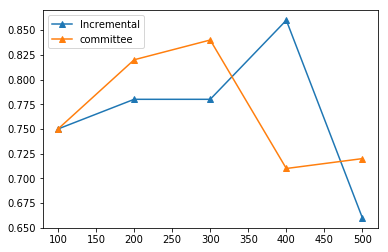

In [28]:
#plot some data
x = range(100,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_acc, marker="^", label="Incremental")
ax.plot(x, comm_acc, marker="^", label="committee")

plt.legend(loc=2)
plt.draw()
plt.show()

## Moving towards training data homogeneity
Trying to get Forst DF's relevant/irrelevant distribution to 1:1